In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-15 12:09:58.574654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 12:09:58.621760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 12:09:58.622422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 12:09:59.348721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read agricultural data into pandas df

In [2]:
#Read CSV into dataframe
ag_data = pd.read_csv('Agrofood_co2_emission.csv')

#Format column headers
ag_data.columns = ag_data.columns.str.replace(' -', '')
ag_data.columns = ag_data.columns.str.replace('(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(')', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = map(str.lower, ag_data.columns)


ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_°c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [3]:
# ag_data.info()
ag_data.shape

(6965, 31)

### Drop Unecessary Columns:
rural population, male population, female population

In [4]:
ag_data = ag_data.drop(['total_population_female', 'total_population_male', 'rural_population'], axis=1)

In [5]:
# ag_data.info()
ag_data.shape

(6965, 28)

### Combine similar columns:

fires = savanna_fires + forest_fires + fires_in_organic_soils + fires_in_humid_tropical_forests
</br>manure_mgmt = manure_applied_to_soils + manure_left_on_pasture + manure_management
</br>food_systems = food_processing + food_packaging + food_retail + food_transport + food_houshold_consumption + agrifood_systems_waste_disposal
</br>ippu_tot = ippu + pesticides_manufacturing + fertilizers_manufacturing
</br>on_farm_energy_use = on-farm_electricity_use + on-farm_energy_use

In [6]:
ag_data['fires'] = ag_data['savanna_fires']+ag_data['forest_fires']+ag_data['fires_in_organic_soils']+ag_data['fires_in_humid_tropical_forests']
ag_data['manure_mgmt'] = ag_data['manure_applied_to_soils']+ag_data['manure_left_on_pasture']+ag_data['manure_management']
ag_data['food_systems'] = ag_data['food_processing']+ag_data['food_packaging']+ag_data['food_retail']+ag_data['food_transport']+ag_data['food_household_consumption']+ag_data['agrifood_systems_waste_disposal']
ag_data['ippu_tot'] = ag_data['ippu']+ag_data['pesticides_manufacturing']+ag_data['fertilizers_manufacturing']
ag_data['on_farm_energy_use'] = ag_data['on-farm_electricity_use'] + ag_data['on-farm_energy_use']

In [7]:
#Drop individual columns
ag_data = ag_data.drop(['savanna_fires', 'forest_fires', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests',
                       'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'food_processing',
                       'food_packaging', 'food_retail', 'food_transport', 'food_household_consumption',
                       'agrifood_systems_waste_disposal', 'ippu', 'pesticides_manufacturing', 'fertilizers_manufacturing',
                       'on-farm_electricity_use', 'on-farm_energy_use'], axis=1)

In [8]:
# ag_data.info()
ag_data.shape

(6965, 15)

### Read Multivariate ENSO Index (MEI) data into pandas df

In [9]:
enso_data = pd.read_csv('meiv2.csv')
enso_data.columns = map(str.lower, enso_data.columns)

#Drop years before 1990 and after 2020
enso_data = enso_data[enso_data['year'] <= 2020]
enso_data = enso_data[enso_data['year'] > 1989]

enso_data = enso_data.set_index('year')

#Calculate yearly average index
enso_data['mei'] = enso_data.mean(axis=1)

#Reset index
enso_data = enso_data.reset_index(names=['year'])

#Drop months columns
enso_data = enso_data.drop(["dj",'jf','fm','ma','am','mj','jj','ja','as','so','on','nd'], axis='columns')

### Join DFs

In [10]:
ag_data = ag_data.merge(enso_data, left_on='year', right_on='year')

In [11]:
ag_data.head()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
0,Afghanistan,1990,205.6077,686.000000,0.0000,-2388.8030,0.0000,2593947.0,2198.963539,0.536167,14.7794,2169.8513,1263.479256,233.782283,NaN,0.2
1,Albania,1990,59.2391,23.520000,110.5705,72.8581,0.0000,1195379.0,3475.291240,0.735750,12.5814,1054.6462,650.148524,1125.636617,366.090800,0.2
2,Algeria,1990,164.2776,4.312000,0.0000,-111.1403,684.9333,13496502.0,22326.596965,1.005583,144.6946,2758.8447,13250.763265,5288.278000,141.633800,0.2
3,American Samoa,1990,NaN,926.342278,0.0000,-58.8991,7.9612,38076.0,5299.122499,0.566500,0.0000,NaN,199.688951,NaN,58.504263,0.2
4,Andorra,1990,NaN,926.342278,0.0000,0.0000,0.0000,51627.0,5576.553292,1.278500,0.0000,NaN,570.011357,1711.187476,74.704263,0.2


In [12]:
# ag_data.info()
ag_data.shape

(6965, 16)

### Read Continents Data into Pandas DF

In [13]:
region_data = pd.read_csv('continents.csv')
# https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
# linked from kaggle: https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region

In [14]:
# drop columns not needed
region_data = region_data.drop(['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2','intermediate-region', 
                                'region-code', 'sub-region-code','intermediate-region-code'], axis=1)

### Merge Regions into Emissions DF

In [15]:
ag_data = ag_data.merge(region_data, left_on='area', right_on='name', how='left').drop(['name'], axis=1)

In [16]:
# manually update region & sub-region information:

def update_regions():

    asia_region = ['China, Hong Kong SAR',
                    'China, Macao SAR',
                    'China, Taiwan Province of',
                    'China, mainland',
                    "Democratic People's Republic of Korea",
                    'Republic of Korea']
    
    for area in asia_region:
        ag_data.loc[ag_data['area']==area,'region']='Asia'
        ag_data.loc[ag_data['area']==area,'sub-region']='East Asia'

    
    # 'British Virgin Islands' # Americas, Latin America and the Caribbean 
    # 'United States Virgin Islands' # Americas, Latin America and the Caribbean
    americas_region = ['British Virgin Islands', 'United States Virgin Islands']    
    
    for area in americas_region:
        ag_data.loc[ag_data['area']==area,'region']='Americas'
        ag_data.loc[ag_data['area']==area,'sub-region']='Latin America and the Caribbean'
    
    #'Palestine' # Asia, Western Asia
    ag_data.loc[ag_data['area']=='Palestine','region']='Asia'
    ag_data.loc[ag_data['area']=='Palestine','sub-region']='Western Asia'

    # 'Wallis and Futuna Islands' # Oceania, Polynesia
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','region']='Oceania'
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','sub-region']='Polynesia'

    # 'Republic of Moldova' # Europe, Eastern Europe
    # 'Serbia and Montenegro' # Europe, Southern Europe
    # 'Channel Islands' # Europe, Northern Europe
    # 'Netherlands (Kingdom of the)' # Europe, Western Europe
    # 'Belgium-Luxembourg' # Europe, Western Europe
    europe_region = ['Republic of Moldova',
                     'Serbia and Montenegro',
                     'Channel Islands',
                     'Netherlands (Kingdom of the)',
                     'Belgium-Luxembourg']
    for area in europe_region:
        ag_data.loc[ag_data['area']==area,'region']='Europe'
        ag_data.loc[ag_data['area']==area,'sub-region']='Wstern Europe'

    ag_data.loc[ag_data['area']=='Republic of Moldova','sub-region']='Eastern Europe'
    ag_data.loc[ag_data['area']=='Serbia and Montenegro','sub-region']='Southern Europe'
    ag_data.loc[ag_data['area']=='Channel Islands','sub-region']='Northern Europe'
    

    # 'Ethiopia PDR' # Afria, Sub-Saharan Africa
    # 'United Republic of Tanzania' # Afria, Sub-Saharan Africa
    # 'Democratic Republic of the Congo' # Africa, Sub-Saharan Africa
    africa_region = ['Ethiopia PDR', 'United Republic of Tanzania', 'Democratic Republic of the Congo']

    for area in africa_region:
        ag_data.loc[ag_data['area']==area,'region']='Africa'
        ag_data.loc[ag_data['area']==area,'sub-region']='Sub-Saharan Africa'


update_regions()

In [17]:
# areas not in region data set
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

area
Czechoslovakia                      3
Netherlands Antilles (former)      21
Pacific Islands Trust Territory     1
Sudan (former)                     22
USSR                                2
Yugoslav SFR                        2
Name: year, dtype: int64

### Evaluate Countries with fewer than 31 years:

In [18]:
ag_data_area = ag_data.groupby('area').sum()
ag_data_area.loc[ag_data_area['year'] != 62155]

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Armenia,58174,867.9864,7193.783413,0.000000e+00,-7.207147e+02,2917.1471,5.635726e+07,9.744722e+04,30.398333,147.4283,12704.6754,3.341263e+04,3.442255e+04,6501.743700,-2.933333
Azerbaijan,58174,4224.8868,540.850300,0.000000e+00,-6.026048e+04,4081.8835,1.347994e+08,2.730205e+05,30.718750,869.7217,57311.7177,1.505620e+05,5.691915e+04,58770.713500,-2.933333
Belarus,58174,12870.7709,26863.926076,1.237739e+06,-1.428863e+06,44432.5316,2.051809e+08,7.723587e+05,43.376000,1139.1979,118212.6124,2.316582e+05,4.285815e+05,99724.217100,-2.933333
Belgium,42210,3792.0467,15238.494610,4.233712e+03,-6.181097e+04,13283.4030,2.241269e+08,7.635175e+05,31.193667,1.7183,79432.2159,2.515535e+05,4.073839e+05,50409.423300,-4.991667
Belgium-Luxembourg,19945,1530.0201,7733.039548,2.170152e+03,-5.741164e+04,10069.1510,1.015337e+08,2.627709e+05,8.839917,1.6377,45740.5605,0.000000e+00,1.623048e+05,0.000000,2.933333
Bosnia and Herzegovina,58174,1935.6795,7215.045405,3.432881e+03,3.991576e+03,0.0000,4.783055e+07,1.499274e+05,34.322833,663.6878,22613.4146,6.318621e+04,4.474690e+04,2141.983400,-2.933333
Croatia,58174,4609.2055,16056.151542,2.582154e+02,-5.376840e+04,8217.6994,6.917302e+07,2.354761e+05,36.427000,358.3903,26695.2161,7.960718e+04,1.300727e+05,23369.795000,-2.933333
Czechia,56182,12395.6109,24001.145653,7.543190e+03,-2.141410e+05,18459.6918,2.156180e+08,5.359970e+05,38.685250,16.0832,47520.7339,3.448612e+05,2.315051e+05,63835.296700,-4.125000
Czechoslovakia,5973,2158.5798,2779.026835,1.048374e+03,-5.914724e+04,2036.8200,3.234779e+07,3.579869e+04,2.250750,2.8005,14987.4518,2.195435e+04,3.603314e+04,13301.816100,2.066667


### Drop Belgium-Luxembourg

Not sure why Belgium & Luxembourg are reported together between 1990 and 2000, but not sure how to accurately split info for these years into each country. Propose dropping these data points. 

In [19]:
# ag_data[ag_data['area'] == 'Belgium']
# ag_data[ag_data['area'] == 'Luxembourg']
# ag_data[ag_data['area'] == 'Belgium-Luxembourg']

ag_data = ag_data[ag_data['area'] != 'Belgium-Luxembourg']

### Drop Czechoslovakia

Czeochoslovakia split into Czechia (Czech Republic) & Slovakia in 1993. Czechoslavakia data between 1990-1992 represents the entire region. Only lose 3 years of data. 

In [20]:
# ag_data[ag_data['area'] == 'Czechia']
# ag_data[ag_data['area'] == 'Czechoslovakia']
# ag_data[ag_data['area'] == 'Slovakia']

ag_data = ag_data[ag_data['area'] != 'Czechoslovakia']

### Drop USSR

Soviet Union fell in 1991. Drop 1990-1991. 

In [21]:
# ag_data[ag_data['area'] == 'USSR']
    
ag_data = ag_data[ag_data['area'] != 'USSR']

### Drop Yugoslavia SFR

SFRY ended in 1991

In [22]:
# ag_data[ag_data['area'] == 'Yugoslav SFR']

ag_data = ag_data[ag_data['area'] != 'Yugoslav SFR']

### Drop Pacific Islands Trust Territory

Split into Micronesia, Marshall Islands, and Palau. Only drop 1990.

In [23]:
# ag_data[ag_data['area'] == 'Pacific Islands Trust Territory']

ag_data = ag_data[ag_data['area'] != 'Pacific Islands Trust Territory']

### Rename Ethiopia PDR to Ethiopia

In [24]:
#ag_data[ag_data['area'] == 'Ethiopia PDR']
#ag_data[ag_data['area'] == 'Ethiopia']

ag_data.loc[ag_data["area"] == "Ethiopia PDR", 'area'] = "Ethiopia"

### Drop Serbia, Montenegro, Serbia & Montenegro

These countries were in a union until 2006. Very difficult to split or interpret this data. Not enough data left if we remove Serbia & Montenegro data points. Propose removing all 3 from datasest. 

In [25]:
ag_data = ag_data[ag_data['area'] != 'Serbia']
ag_data = ag_data[ag_data['area'] != 'Montenegro']
ag_data = ag_data[ag_data['area'] != 'Serbia and Montenegro']

### Drop Sudan(former), Sudan, and South Sudan

Split into two countries in 2011. Very difficult to split or interpret data prior to split. Propose removing all 3 from dataset. 

In [26]:
ag_data = ag_data[ag_data['area'] != 'Sudan (former)']
ag_data = ag_data[ag_data['area'] != 'Sudan']
ag_data = ag_data[ag_data['area'] != 'South Sudan']

### Drop Netherlands Antiles

Was a country made up of dutch colonized islands. Dissolved in 2010. Not sufficient data to keep. Propose removing. 

In [27]:
ag_data = ag_data[ag_data['area'] != 'Netherlands Antilles (former)']

### Confirm no areas are missing region data

In [28]:
# areas not in region data set
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

Series([], Name: year, dtype: int64)

### Impute Null Values

Compute average emissions for all columns, group by year and sub-region
</br>Replace null values with average value for that year and sub-region

In [29]:
ag_data.isnull().sum()

area                            0
year                            0
crop_residues                1368
rice_cultivation                0
drained_organic_soils_co2       0
forestland                    493
net_forest_conversion         493
urban_population                0
total_emission                  0
average_temperature_°c          0
fires                         155
manure_mgmt                   906
food_systems                  456
ippu_tot                      743
on_farm_energy_use            930
mei                             0
region                          0
sub-region                      0
dtype: int64

In [30]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
American Samoa,62155,0.0,35912.514945,0.0000,-1597.6311,258.1007,1489097.0,170441.802466,26.352765,0.0000,0.0000,5266.409674,0.000000,1471.136146,-2.058333
Andorra,62155,0.0,28716.610633,0.0000,0.0000,0.0000,2038525.0,163914.151678,39.800000,0.0000,0.0000,8542.204360,53007.193557,2340.875946,-2.058333
Anguilla,62155,0.0,81021.342888,0.0000,0.0000,0.0000,380791.0,382477.950827,21.425000,0.0000,0.0000,19863.982579,86898.124683,147.057000,-2.058333
Aruba,62155,0.0,60320.883163,0.0000,-1.7989,0.0000,1311424.0,205325.247943,24.766342,0.0000,0.0000,22373.504275,50012.139891,887.887100,-2.058333
Bahrain,4025,0.0,1515.513286,0.0000,-5.1600,0.0000,2305816.0,14630.473086,3.334500,0.0000,66.1694,5475.665800,7499.039600,0.000000,-0.683333
Bermuda,60165,0.0,46947.094321,0.0000,0.0000,0.0000,1893961.0,311920.136507,24.500627,0.0000,0.0000,17860.609918,0.000000,1040.755784,-2.258333
British Virgin Islands,62155,0.0,81305.494934,0.0000,0.0000,0.0000,327967.0,469065.447763,21.869667,0.6844,0.0000,0.000000,91449.759165,17090.796518,-2.058333
Cayman Islands,62155,0.0,64799.059337,0.0000,-54.4794,96.7672,1454896.0,212409.758811,30.551787,0.0000,0.0000,17867.428100,0.000000,766.191146,-2.058333
Channel Islands,62155,0.0,307414.102948,0.0000,0.0000,0.0000,1472782.0,989849.947276,33.245083,0.0000,0.0000,0.000000,0.000000,0.000000,-2.058333


In [31]:
#Replace null values with calculated sub-region averages by year

def impute_null(df):
    cols = df.columns.tolist()
    for col in cols:
        null_indeces = df[df[col].isnull()].index.tolist()
        for index in null_indeces:
            year = df['year'][index]
            sub_region = df['sub-region'][index]
            new_value = df[(df['year']==year) & (df['sub-region']==sub_region)][col].aggregate('mean')
            df[col][index] = new_value
    return df

In [32]:
ag_data = impute_null(ag_data)

In [33]:
ag_data.isnull().sum()

area                         0
year                         0
crop_residues                0
rice_cultivation             0
drained_organic_soils_co2    0
forestland                   0
net_forest_conversion        0
urban_population             0
total_emission               0
average_temperature_°c       0
fires                        0
manure_mgmt                  0
food_systems                 0
ippu_tot                     0
on_farm_energy_use           0
mei                          0
region                       0
sub-region                   0
dtype: int64

### Visualize Distribution of Vars

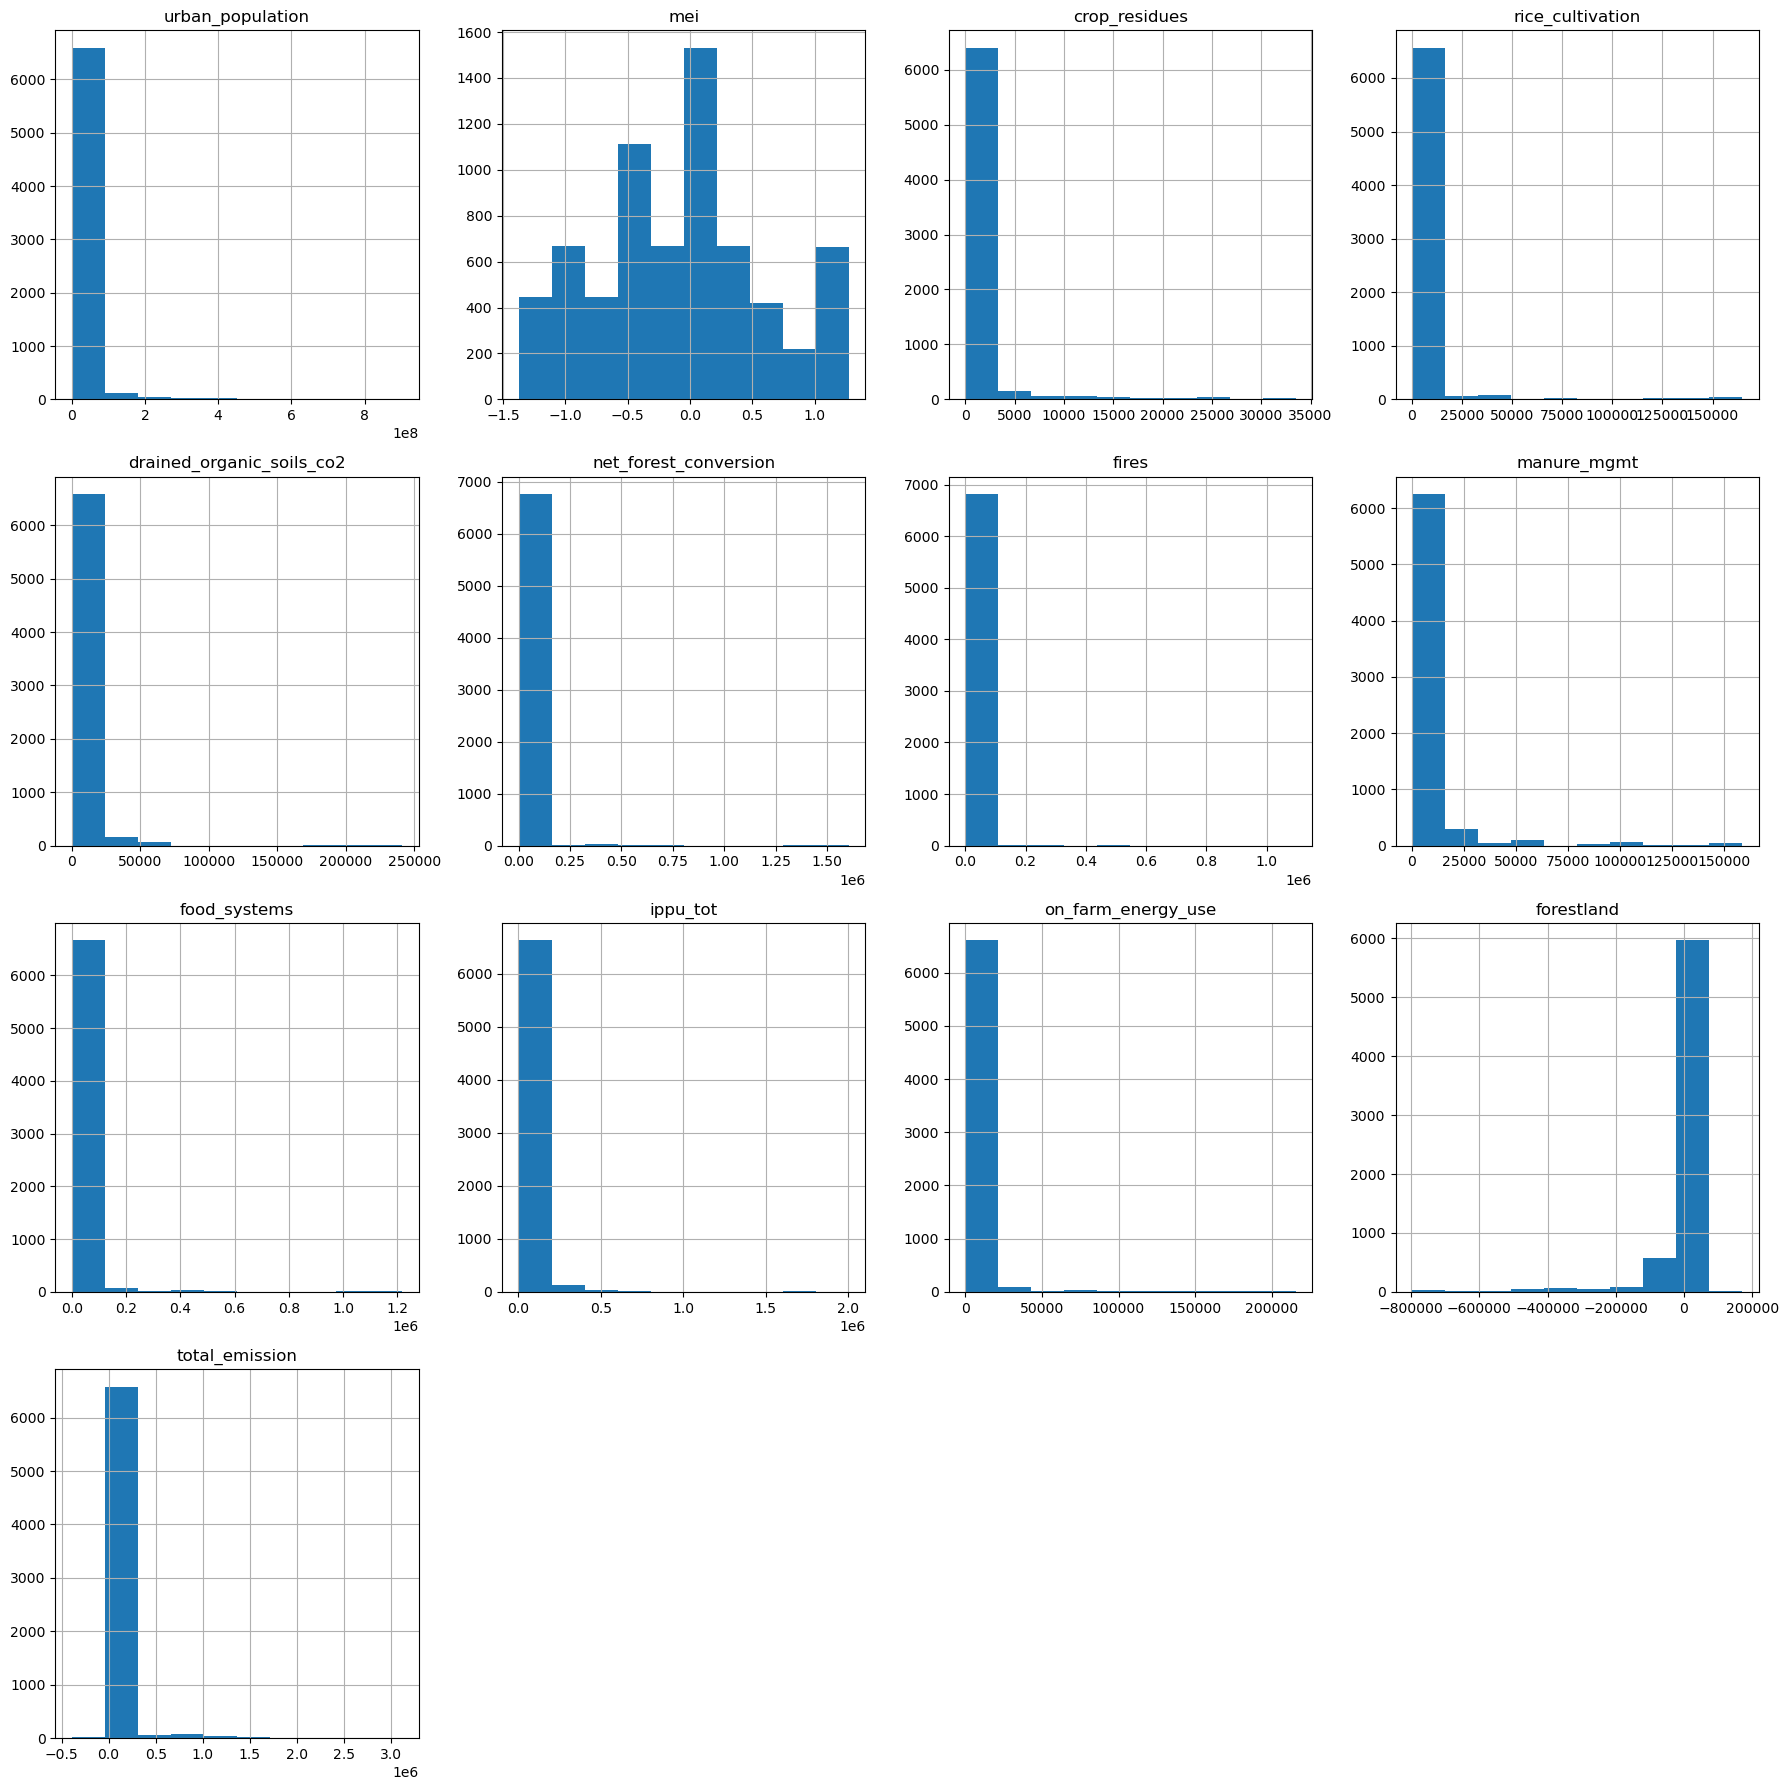

In [34]:
vars = [
 'urban_population',
 'mei',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use',
 'forestland',
 'total_emission']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(ag_data, vars, 4,4)

### Add Log Transforms of non-normally distributed variables

In [35]:
log_vars = [
 'urban_population',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use']

for col in log_vars:
    ag_data['log_'+col] = np.log(ag_data[col]+1)

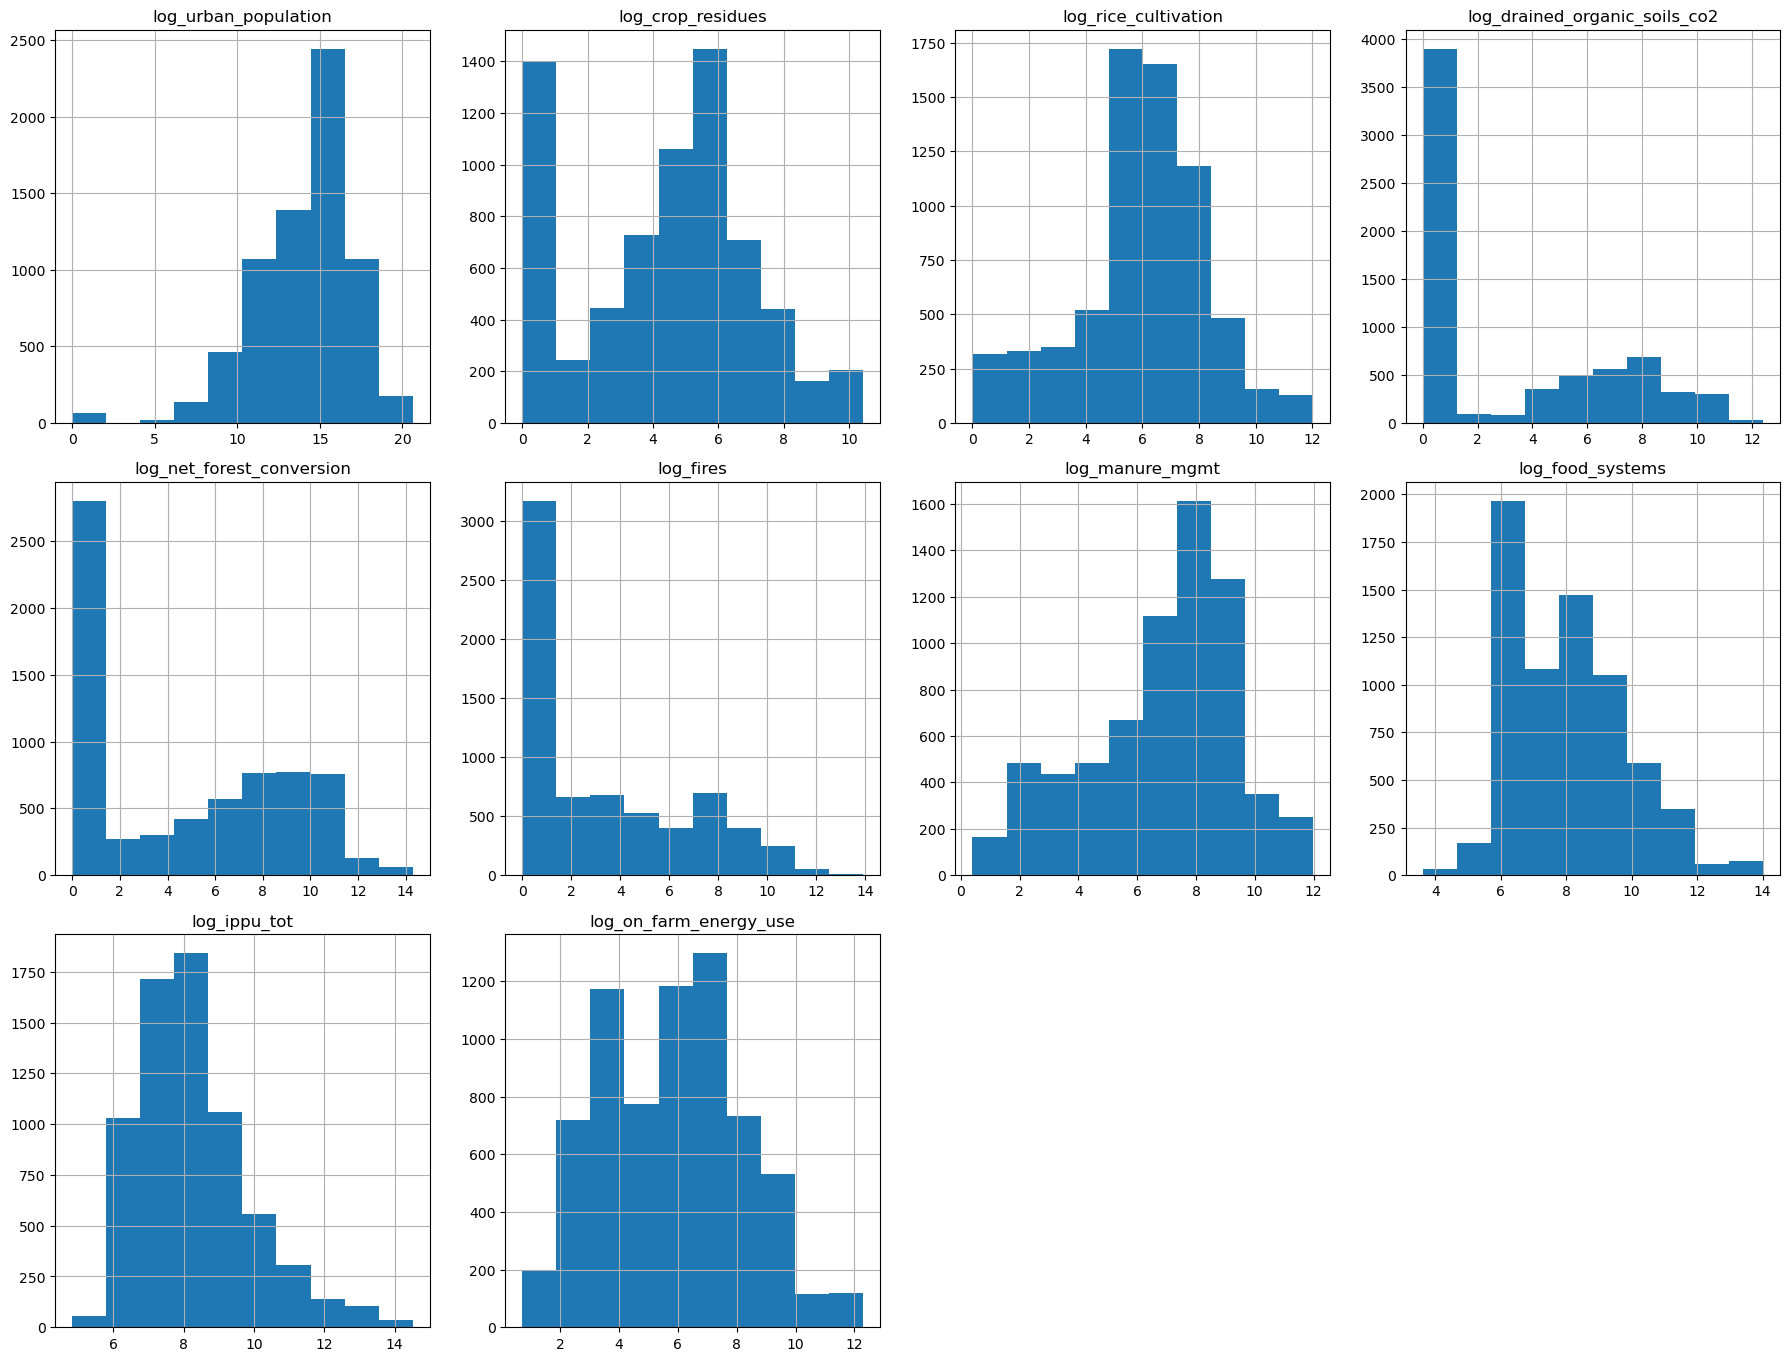

In [37]:
log_vars = [
 'log_urban_population',
 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(ag_data, log_vars, 4,4)

### Compute rolling totals & Add new columns

In [38]:
def calc_rolling_total(df, column, time_period):
    return (df
            .groupby('area')[column]
            .transform(lambda df: df.rolling(time_period).sum()))

In [39]:
cols = [ 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use', 'forestland', 'total_emission']



In [40]:
for col in cols:
    ag_data['5yr_'+str(col)] = calc_rolling_total(ag_data, col, 5)

In [41]:
for col in cols:
    ag_data['10yr_'+str(col)] = calc_rolling_total(ag_data, col, 10)

In [42]:
for col in cols:
    ag_data['20yr_'+str(col)] = calc_rolling_total(ag_data, col, 20)

In [43]:
ag_data.tail()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,...,20yr_log_rice_cultivation,20yr_log_drained_organic_soils_co2,20yr_log_net_forest_conversion,20yr_log_fires,20yr_log_manure_mgmt,20yr_log_food_systems,20yr_log_ippu_tot,20yr_log_on_farm_energy_use,20yr_forestland,20yr_total_emission
6960,Wallis and Futuna Islands,2020,0.00930,4112.742030,0.0000,0.0000,0.0000,0.0,11739.701561,1.232333,...,164.818330,0.000000,28.547824,0.000000,68.265247,116.345228,142.738293,126.217831,-72.6645,2.286121e+05
6961,Western Sahara,2020,408.44432,926.342278,0.0000,-104.5657,0.0000,518663.0,13153.118933,2.068000,...,136.646455,0.000000,47.225392,0.000000,162.235393,198.960890,190.779569,161.741662,-4814.5545,2.596462e+05
6962,Yemen,2020,42.74110,796.196122,0.0000,0.0000,0.0000,11465414.0,16313.168415,1.320126,...,130.623976,0.000000,0.000000,0.182233,158.536418,177.327368,153.171754,147.551011,0.0000,2.949848e+05
6963,Zambia,2020,205.72660,48.521800,14566.6658,0.0000,19047.2568,8336381.0,95970.904147,0.714417,...,73.473761,191.665794,180.499632,218.159446,151.142908,154.445054,144.638108,87.940656,0.0000,1.740837e+06
6964,Zimbabwe,2020,108.30220,7.973300,0.0000,76500.2982,10662.4408,5700460.0,96505.221853,0.189000,...,29.523106,0.000000,185.509734,152.034504,160.989144,152.011518,153.573349,147.113034,388368.0030,8.314149e+05


### Reorder Columns

In [46]:
reordered_cols = ['area', 'region', 'sub-region', 'year', 'urban_population', 'mei', 'crop_residues',
                  'rice_cultivation', 'drained_organic_soils_co2','net_forest_conversion', 'fires', 
                  'manure_mgmt', 'food_systems','ippu_tot', 'on_farm_energy_use', 'forestland', 
                  'total_emission', 'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
                  'log_drained_organic_soils_co2','log_net_forest_conversion','log_fires','log_manure_mgmt',
                  'log_food_systems','log_ippu_tot','log_on_farm_energy_use',
                   '5yr_log_crop_residues',
 '5yr_log_rice_cultivation',
 '5yr_log_drained_organic_soils_co2',
 '5yr_log_net_forest_conversion',
 '5yr_log_fires',
 '5yr_log_manure_mgmt',
 '5yr_log_food_systems',
 '5yr_log_ippu_tot',
 '5yr_log_on_farm_energy_use',
 '5yr_forestland',
 '5yr_total_emission',
 '10yr_log_crop_residues',
 '10yr_log_rice_cultivation',
 '10yr_log_drained_organic_soils_co2',
 '10yr_log_net_forest_conversion',
 '10yr_log_fires',
 '10yr_log_manure_mgmt',
 '10yr_log_food_systems',
 '10yr_log_ippu_tot',
 '10yr_log_on_farm_energy_use',
 '10yr_forestland',
 '10yr_total_emission',
 '20yr_log_crop_residues',
 '20yr_log_rice_cultivation',
 '20yr_log_drained_organic_soils_co2',
 '20yr_log_net_forest_conversion',
 '20yr_log_fires',
 '20yr_log_manure_mgmt',
 '20yr_log_food_systems',
 '20yr_log_ippu_tot',
 '20yr_log_on_farm_energy_use',
 '20yr_forestland',
 '20yr_total_emission','average_temperature_°c']

ag_data = ag_data[reordered_cols]

ag_data.head()

,area,region,sub-region,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,...,20yr_log_drained_organic_soils_co2,20yr_log_net_forest_conversion,20yr_log_fires,20yr_log_manure_mgmt,20yr_log_food_systems,20yr_log_ippu_tot,20yr_log_on_farm_energy_use,20yr_forestland,20yr_total_emission,average_temperature_°c
0,Afghanistan,Asia,Southern Asia,1990,2593947.0,0.2,205.607700,686.000000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536167
1,Albania,Europe,Southern Europe,1990,1195379.0,0.2,59.239100,23.520000,110.5705,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735750
2,Algeria,Africa,Northern Africa,1990,13496502.0,0.2,164.277600,4.312000,0.0000,684.9333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005583
3,American Samoa,Oceania,Polynesia,1990,38076.0,0.2,0.017500,926.342278,0.0000,7.9612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566500
4,Andorra,Europe,Southern Europe,1990,51627.0,0.2,463.085667,926.342278,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.278500


## Split train, validation, and test data

~ 80% (1990-2014)
</br>~ 10% (2015-2017)
</br>~ 10% (2018-2020)

In [47]:
train = ag_data[ag_data['year'] <= 2014]
val = ag_data[(ag_data['year'] >= 2015) & (ag_data['year'] <= 2017)]
test = ag_data[ag_data['year'] >= 2018]

### Standaradize input variables in training datset

In [48]:
#Create a list of all features that need to be standardized
features = ['urban_population', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'net_forest_conversion', 'fires',
            'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'forestland', 'total_emission', 'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
                  'log_drained_organic_soils_co2','log_net_forest_conversion','log_fires','log_manure_mgmt',
                  'log_food_systems','log_ippu_tot','log_on_farm_energy_use',
                   '5yr_log_crop_residues',
 '5yr_log_rice_cultivation',
 '5yr_log_drained_organic_soils_co2',
 '5yr_log_net_forest_conversion',
 '5yr_log_fires',
 '5yr_log_manure_mgmt',
 '5yr_log_food_systems',
 '5yr_log_ippu_tot',
 '5yr_log_on_farm_energy_use',
 '5yr_forestland',
 '5yr_total_emission',
 '10yr_log_crop_residues',
 '10yr_log_rice_cultivation',
 '10yr_log_drained_organic_soils_co2',
 '10yr_log_net_forest_conversion',
 '10yr_log_fires',
 '10yr_log_manure_mgmt',
 '10yr_log_food_systems',
 '10yr_log_ippu_tot',
 '10yr_log_on_farm_energy_use',
 '10yr_forestland',
 '10yr_total_emission',
 '20yr_log_crop_residues',
 '20yr_log_rice_cultivation',
 '20yr_log_drained_organic_soils_co2',
 '20yr_log_net_forest_conversion',
 '20yr_log_fires',
 '20yr_log_manure_mgmt',
 '20yr_log_food_systems',
 '20yr_log_ippu_tot',
 '20yr_log_on_farm_energy_use',
 '20yr_forestland',
 '20yr_total_emission']

In [49]:
#Standardize train dataset

scaler = StandardScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])

In [50]:
#Standardize val and test datasets using train mean and st deviation

val[features] = scaler.transform(val[features])
test[features] = scaler.transform(test[features])

In [54]:
#Verify standardization was performed correctly
train[features].describe()
val[features].describe()
test[features].describe()

,urban_population,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,...,20yr_log_rice_cultivation,20yr_log_drained_organic_soils_co2,20yr_log_net_forest_conversion,20yr_log_fires,20yr_log_manure_mgmt,20yr_log_food_systems,20yr_log_ippu_tot,20yr_log_on_farm_energy_use,20yr_forestland,20yr_total_emission
count,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,...,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,0.116374,0.083752,0.005989,0.015014,-0.045295,-0.018412,0.038744,0.091264,0.154771,0.041471,...,0.022760,0.009733,-0.030964,-0.056416,0.026048,0.065136,0.079197,0.040193,-0.013960,0.030791
std,1.530788,1.261176,0.999224,1.142795,0.593574,0.804096,1.033431,1.513134,1.850403,1.279532,...,0.975565,1.001991,0.962498,0.983821,0.988799,1.011504,1.031899,0.982348,1.139629,1.217037
min,-0.265910,-0.299286,-0.242590,-0.223168,-0.175706,-0.149393,-0.365941,-0.250715,-0.219144,-0.245022,...,-2.539833,-0.799442,-1.108545,-0.948727,-2.582538,-2.346139,-1.869609,-2.122049,-10.011477,-1.454835
25%,-0.260305,-0.296631,-0.228707,-0.223168,-0.175706,-0.149393,-0.353990,-0.242837,-0.205643,-0.241967,...,-0.252131,-0.799442,-1.108545,-0.942274,-0.540899,-0.850914,-0.677209,-0.844172,0.197959,-0.286436
50%,-0.209105,-0.250259,-0.209461,-0.223168,-0.174922,-0.149232,-0.257500,-0.205128,-0.186362,-0.216318,...,0.106602,-0.799442,-0.125043,-0.457069,0.266497,0.030470,-0.152039,0.122563,0.260002,-0.247904
75%,-0.088563,-0.102241,-0.156041,-0.178277,-0.131026,-0.137171,-0.026404,-0.108691,-0.109994,-0.143483,...,0.589294,0.921985,0.876806,0.646622,0.756030,0.663337,0.610327,0.713161,0.263738,-0.137899
max,14.865018,9.339645,8.199960,15.404822,6.036978,16.702126,7.275415,15.369895,19.354377,11.550983,...,2.516833,2.447319,2.232996,2.537300,2.048928,3.263848,3.820552,2.693324,1.273320,11.367941


In [55]:
#Confirm size of train, val, and test datasets

print(train.shape)
print(val.shape)
print(test.shape)

(5504, 61)
(669, 61)
(669, 61)


### Export Train, Val, Test Data to CSV

In [56]:
train.to_csv('train_data.csv',index=False)
val.to_csv('val_data.csv',index=False)
test.to_csv('test_data.csv',index=False)